# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import helper_functions as hf
import matplotlib.pyplot as plt
import itertools
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
data_wide = pd.read_csv('./zillow_data.csv')

In [3]:
data_wide.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
data_long = hf.melt_data_v2(data_wide)
data_long['time'] = pd.to_datetime(data_long['time'], format='%Y-%m-%d')
data_long['RegionName'] = data_long['RegionName'].astype('str')

data_long.set_index(keys='time', inplace=True)
data_long.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


In this project, we will be looing at zip codes in Florida, specifically areas near Orlando

In [5]:
#separate out areas within the state of Florida
df_fl = data_long.loc[data_long.State=='FL']
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


In [6]:
df_fl.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         7155
CountyName       0
SizeRank         0
value            0
dtype: int64

In [7]:
df_fl.info()
df_fl.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


# Step 2: Data Preprocessing

# Step 3: EDA and Visualization

In [8]:
from matplotlib import rc

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [9]:
# In the state array, there are 51 entries.
data_long.State.unique().shape

(51,)

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


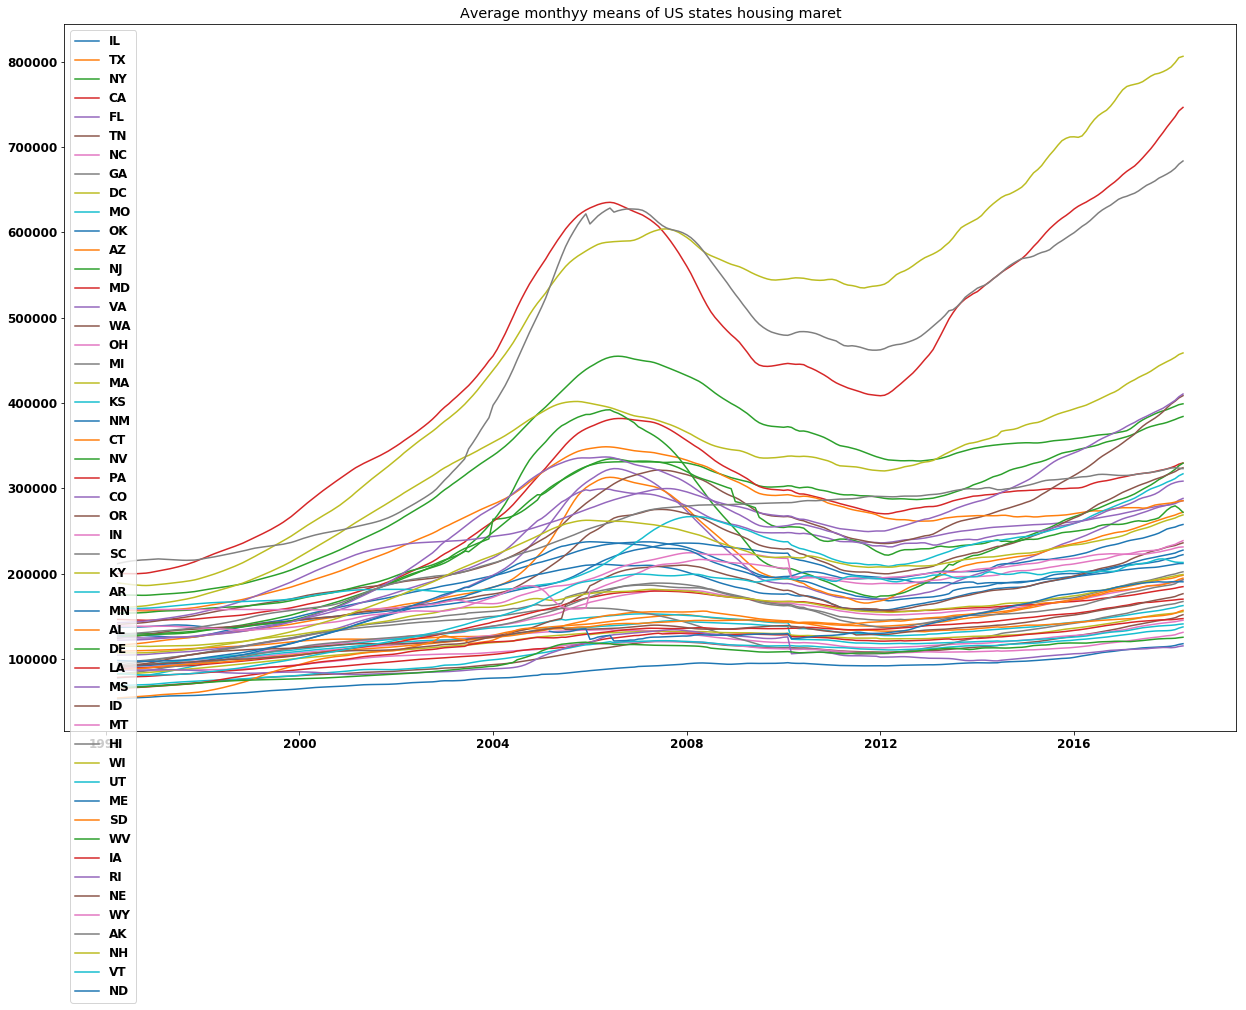

In [10]:
#Looking at each state to see averages over the years
plt.figure(figsize=(21,13))
for state in data_long.State.unique():
    state_data = data_long.loc[(data_long.State==state), ['value']].resample('MS').mean()
    plt.plot(state_data, label=state)
    
plt.title('Average monthyy means of US states housing maret')
plt.legend()
plt.show()

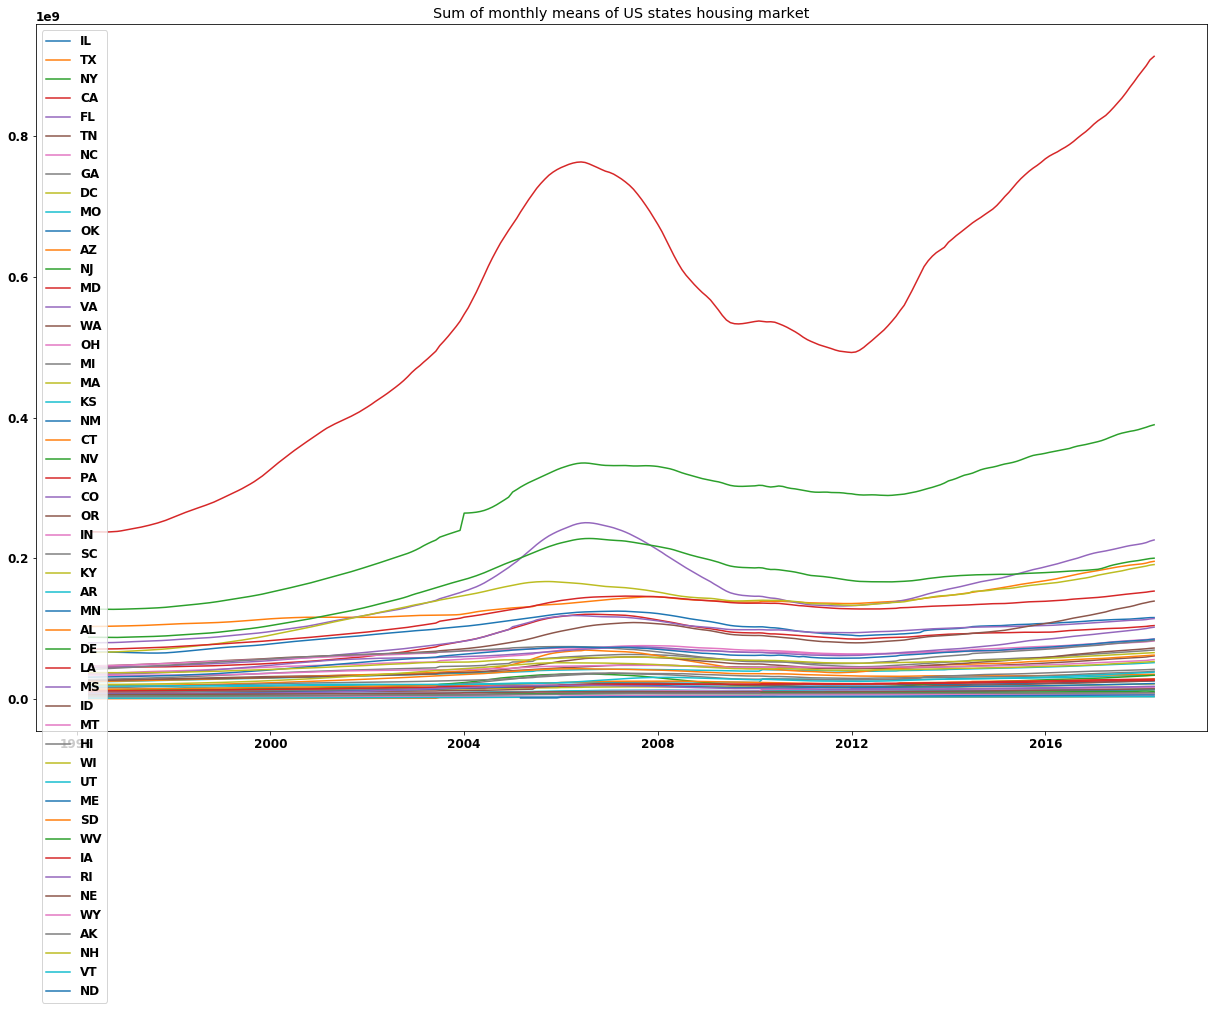

In [11]:
#Looking at each state to see the total means over the years
plt.figure(figsize=(21,13))
for state in data_long.State.unique():
    state_data = data_long.loc[(data_long.State==state), ['value']].resample('MS').sum()
    plt.plot(state_data, label=state)
    
plt.title('Sum of monthly means of US states housing market')
plt.legend()
plt.show()

In [12]:
df_fl.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


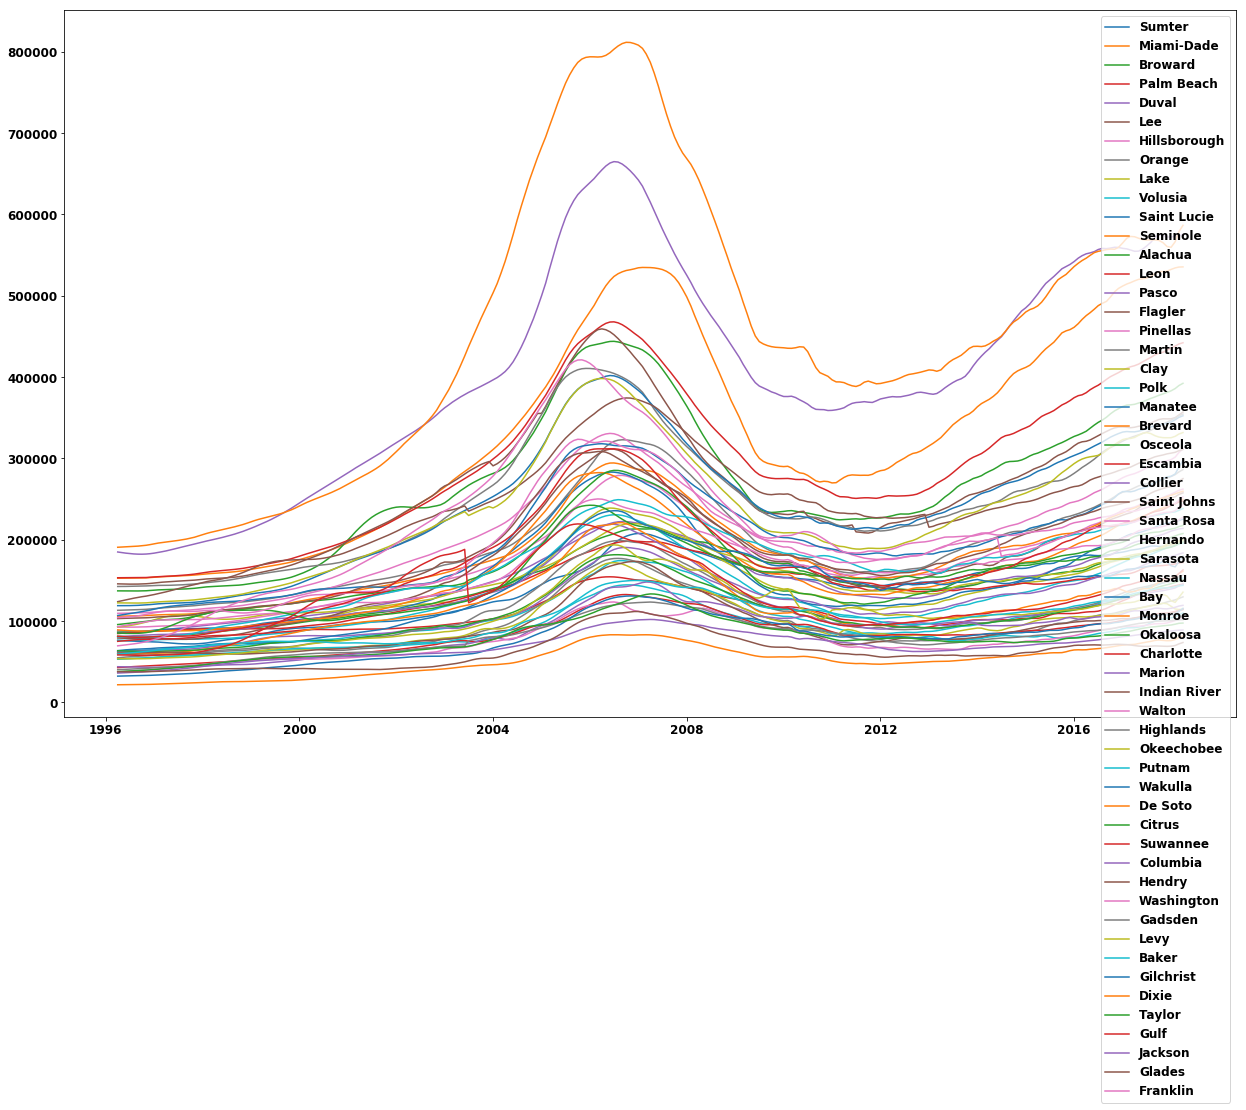

In [13]:
# loop to print out the counties for the state of Florida
plt.figure(figsize=(21,13))
for county in df_fl.CountyName.unique():
    county_data = df_fl.loc[(df_fl.CountyName==county), ['value']].resample('MS').mean()
    plt.plot(county_data, label=county)
plt.legend()
plt.show()

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


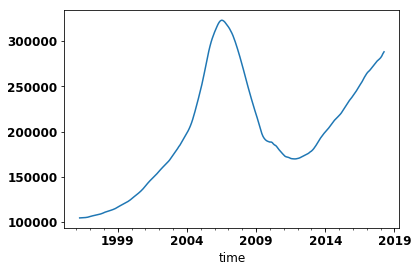

In [14]:
# Florida monthly means ovre the years
florida_monthly = df_fl.groupby(pd.Grouper(freq='MS'))
florida_monthly.value.mean().plot()

In [57]:
## Separate out Florida by year 2011
df_fl_2011 = df_fl['2011':]
# df_fl_2011.loc[(df_fl.CountyName=='Orange'), ['value']].resample('MS').mean()
df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()

,value
time,
2011-01-01,165019.444444
2011-02-01,162794.444444
2011-03-01,160980.555556
2011-04-01,160016.666667
2011-05-01,159455.555556
2011-06-01,159119.444444
2011-07-01,159497.222222
2011-08-01,160261.111111
2011-09-01,160766.666667


No handles with labels found to put in legend.


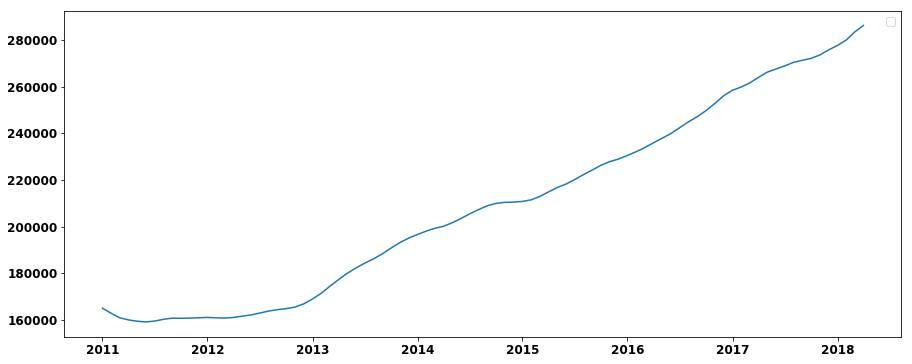

In [58]:
# Separate out the areas that are part of Orange County, Florida BY YEAR 2011
orange_county = df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()
plt.plot(orange_county)
plt.legend()
plt.show()

# df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()

In [59]:
# Separate out the areas that are part of Orange County, Florida
# orange_county = df_fl.loc[(df_fl.CountyName=='Orange'), ['value']].resample('MS').mean()
# plt.plot(orange_county)
# plt.legend()
# plt.show()

Based on our graph below, there appears to be some seasonality that is occurring within the housing market for orange county as time passes by.

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


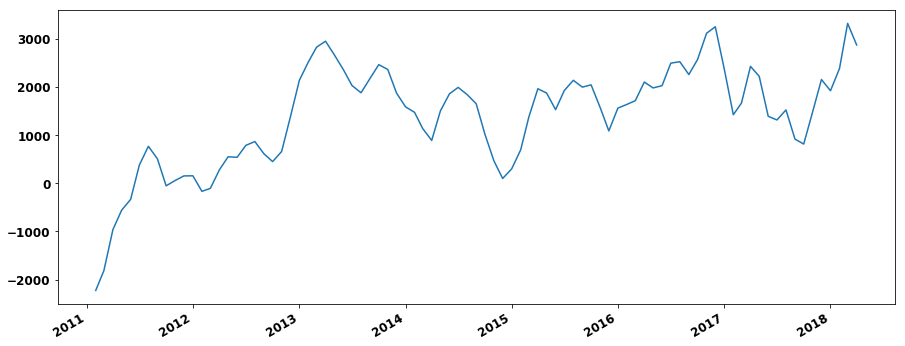

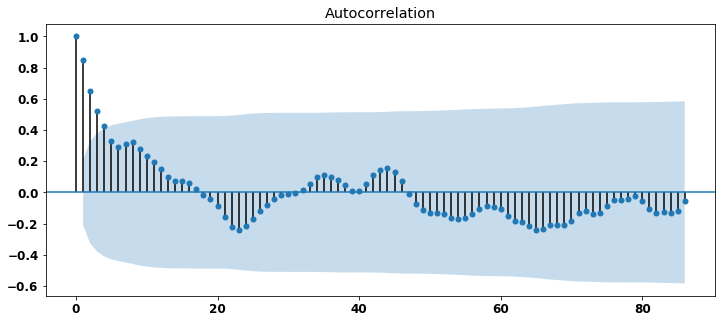

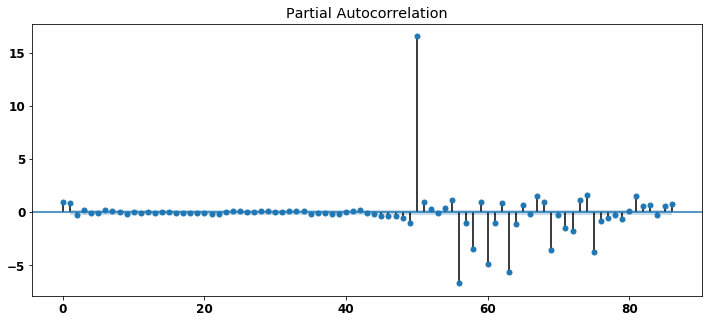

In [60]:
## Looking at difference by year
# Look at the distribution of the diffs and look at the one with the smallest standard deviation
orange_county_diff = orange_county.diff(periods=1)
plt.plot(orange_county_diff)
rcParams['figure.figsize'] = (12, 5)

plt.gcf().autofmt_xdate()
rcParams['figure.figsize'] = (12, 5)

plot_acf(orange_county_diff.dropna());
plot_pacf(orange_county_diff.dropna());

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


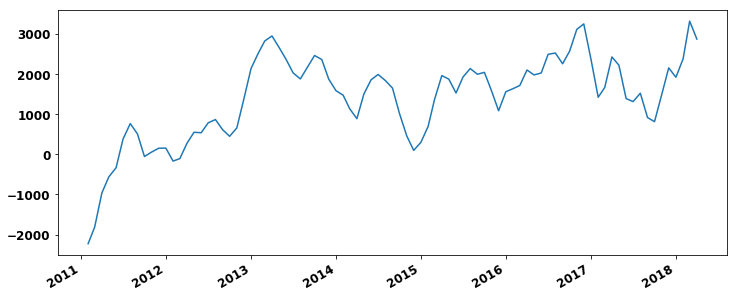

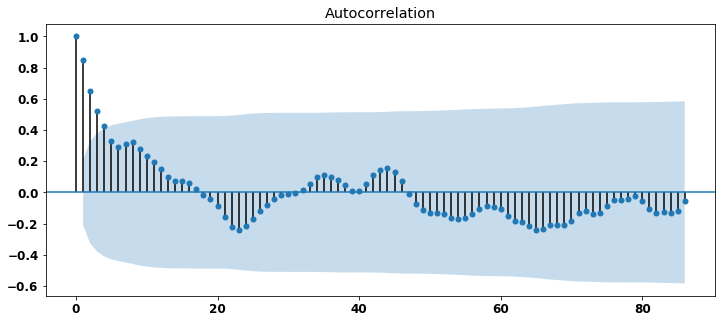

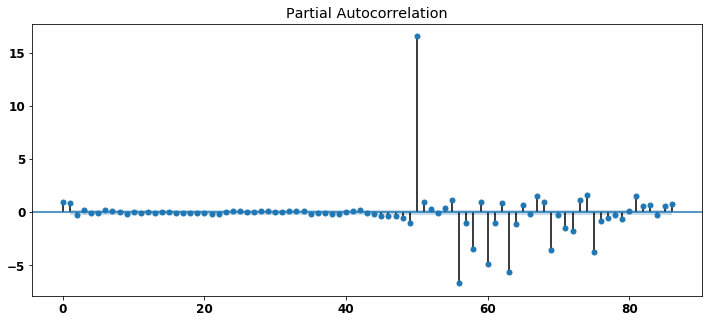

In [61]:
## Looking at difference by year
# Look at the distribution of the diffs and look at the one with the smallest standard deviation
orange_county_diff = orange_county.diff(periods=1)
plt.plot(orange_county_diff)
rcParams['figure.figsize'] = (12, 5)

plt.gcf().autofmt_xdate()
rcParams['figure.figsize'] = (12, 5)

plot_acf(orange_county_diff.dropna());
plot_pacf(orange_county_diff.dropna());

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 864x360 with 0 Axes>

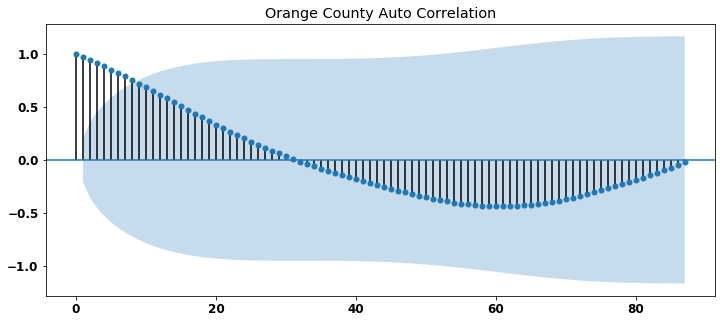

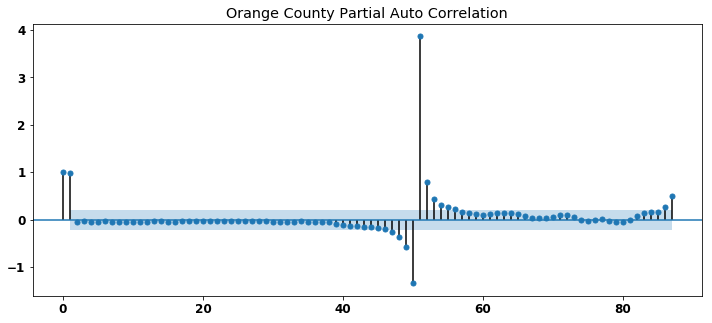

In [62]:
## Using ACF & PACF to view differencing for time series##

plt.gcf().autofmt_xdate()
rcParams['figure.figsize'] = (12, 5)

plot_acf(orange_county, title='Orange County Auto Correlation');
plot_pacf(orange_county, title='Orange County Partial Auto Correlation');

Based on what we see in our partial correlation plot, there is a high negative correlation somewhere between 220 - 245 lags.

This high negative appears at lag = 180 months

In [63]:
# orange_county_diff = orange_county.diff(periods=180)

# plot_acf(orange_county, lags=181);
# plot_pacf(orange_county, lags=181);

### Seasonal Decomposition

In [64]:
# data.head()

# seasonal_decompose()

# trend = 
# seasonal = 
# residual = 

# Step 4: Reshape from Wide to Long Format

In [65]:
orange_county

,value
time,
2011-01-01,165019.444444
2011-02-01,162794.444444
2011-03-01,160980.555556
2011-04-01,160016.666667
2011-05-01,159455.555556
2011-06-01,159119.444444
2011-07-01,159497.222222
2011-08-01,160261.111111
2011-09-01,160766.666667


# Step 5: ARIMA Modeling

Before getting into the ARIMA modeling, combinations for the model needs to be created.  
Here, the parameters for all combinations of seasons are also added to our values for seasonal & non seasonal arima modeling.

In [66]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# pdqs = [(x[0], x[1], x[2], 12) for x in pdq]
    
pdqs = []    
for i in range(0,13):
    for x in pdq:
        pdqs.append((x[0], x[1], x[2], i))

pdqs

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 1),
 (0, 1, 0, 1),
 (0, 1, 1, 1),
 (1, 0, 0, 1),
 (1, 0, 1, 1),
 (1, 1, 0, 1),
 (1, 1, 1, 1),
 (0, 0, 0, 2),
 (0, 0, 1, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 2),
 (1, 0, 0, 2),
 (1, 0, 1, 2),
 (1, 1, 0, 2),
 (1, 1, 1, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 3),
 (0, 1, 0, 3),
 (0, 1, 1, 3),
 (1, 0, 0, 3),
 (1, 0, 1, 3),
 (1, 1, 0, 3),
 (1, 1, 1, 3),
 (0, 0, 0, 4),
 (0, 0, 1, 4),
 (0, 1, 0, 4),
 (0, 1, 1, 4),
 (1, 0, 0, 4),
 (1, 0, 1, 4),
 (1, 1, 0, 4),
 (1, 1, 1, 4),
 (0, 0, 0, 5),
 (0, 0, 1, 5),
 (0, 1, 0, 5),
 (0, 1, 1, 5),
 (1, 0, 0, 5),
 (1, 0, 1, 5),
 (1, 1, 0, 5),
 (1, 1, 1, 5),
 (0, 0, 0, 6),
 (0, 0, 1, 6),
 (0, 1, 0, 6),
 (0, 1, 1, 6),
 (1, 0, 0, 6),
 (1, 0, 1, 6),
 (1, 1, 0, 6),
 (1, 1, 1, 6),
 (0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7),
 (0, 0, 0, 8),
 (0, 0, 1, 8),
 (0, 1, 0,

In [67]:
## NEED TO TURN THIS INTO A FUNCTION THAT I CAN PASS
## EACH ZIP CODE INTO AS A DATAFRAME, 
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(orange_county,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic, output.bic])
            print('ARIMA {} x {} : AIC Calculated ={}, BIC Calculated ={}'.format(comb, combs, output.aic, output.bic))
        except:
            continue

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA (0, 0, 0) x (0, 0, 0, 0) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 0) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 0) x (1, 0, 0, 0) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (0, 0, 0) x (1, 0, 1, 0) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (0, 0, 0) x (0, 0, 0, 1) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 1) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 0) x (0, 1, 0, 1) : AIC Calculated =1530.241481858444, BIC Calculated =1532.6958291546975
ARIMA (0, 0, 0) x (0, 1, 1, 1) : AIC Calculated =1409.4932852356374, BIC Calculated =1414.378587748618
ARIMA (0, 0, 0) x (1, 0, 0, 1) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (0, 0, 0) x (1, 0, 1, 1) : AIC Calculated =1335.0086095856423, BIC

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (0, 1, 1, 2) : AIC Calculated =1583.3693129970277, BIC Calculated =1588.2069942126209
ARIMA (0, 0, 0) x (1, 0, 0, 2) : AIC Calculated =1535.9801648551256, BIC Calculated =1540.8888594476327


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 2) : AIC Calculated =1509.1863884009088, BIC Calculated =1516.5143421703797
ARIMA (0, 0, 0) x (1, 1, 0, 2) : AIC Calculated =1434.3828780497004, BIC Calculated =1439.244511647387


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 2) : AIC Calculated =1417.33036776373, BIC Calculated =1424.58688958712
ARIMA (0, 0, 0) x (0, 0, 0, 3) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 3) : AIC Calculated =81526.54824929158, BIC Calculated =81531.40988288926
ARIMA (0, 0, 0) x (0, 1, 0, 3) : AIC Calculated =1674.932295364945, BIC Calculated =1677.3631121637884


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (0, 1, 1, 3) : AIC Calculated =1616.7886706081551, BIC Calculated =1621.5775689175
ARIMA (0, 0, 0) x (1, 0, 0, 3) : AIC Calculated =1575.8035338702682, BIC Calculated =1580.6888363832488


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 3) : AIC Calculated =1553.8535520354576, BIC Calculated =1561.1460024319874
ARIMA (0, 0, 0) x (1, 1, 0, 3) : AIC Calculated =1487.4411113422705, BIC Calculated =1492.254549836799


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 3) : AIC Calculated =1469.8777953166505, BIC Calculated =1477.0611427806678
ARIMA (0, 0, 0) x (0, 0, 0, 4) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 4) : AIC Calculated =106950.52585504776, BIC Calculated =106955.36353626335
ARIMA (0, 0, 0) x (0, 1, 0, 4) : AIC Calculated =1701.144362263362, BIC Calculated =1703.5632028711586
ARIMA (0, 0, 0) x (0, 1, 1, 4) : AIC Calculated =1624.2122936183157, BIC Calculated =1628.9511893232498
ARIMA (0, 0, 0) x (1, 0, 0, 4) : AIC Calculated =1595.943120698581, BIC Calculated =1600.8047542962677


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 4) : AIC Calculated =1584.9700196843391, BIC Calculated =1592.226541507729
ARIMA (0, 0, 0) x (1, 1, 0, 4) : AIC Calculated =1505.2220744064757, BIC Calculated =1509.9861276758236


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 4) : AIC Calculated =1486.9606178570305, BIC Calculated =1494.0689614144314
ARIMA (0, 0, 0) x (0, 0, 0, 5) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 5) : AIC Calculated =132258.44333168946, BIC Calculated =132263.25677018397
ARIMA (0, 0, 0) x (0, 1, 0, 5) : AIC Calculated =1716.1154148785517, BIC Calculated =1718.522134125816
ARIMA (0, 0, 0) x (0, 1, 1, 5) : AIC Calculated =1617.7426700213252, BIC Calculated =1622.4302808650325
ARIMA (0, 0, 0) x (1, 0, 0, 5) : AIC Calculated =1605.504184467378, BIC Calculated =1610.3418656829713
ARIMA (0, 0, 0) x (1, 0, 1, 5) : AIC Calculated =1575.6799591319168, BIC Calculated =1582.9001168737095
ARIMA (0, 0, 0) x (1, 1, 0, 5) : AIC Calculated =1502.1808998689037, BIC Calculated =1506.8943175222828


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 5) : AIC Calculated =1482.1989272392923, BIC Calculated =1489.2303435048534
ARIMA (0, 0, 0) x (0, 0, 0, 6) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 6) : AIC Calculated =157673.70186289368, BIC Calculated =157678.49076120302
ARIMA (0, 0, 0) x (0, 1, 0, 6) : AIC Calculated =1723.8310959642636, BIC Calculated =1726.225545118936
ARIMA (0, 0, 0) x (0, 1, 1, 6) : AIC Calculated =1603.462599190722, BIC Calculated =1608.0975754177946
ARIMA (0, 0, 0) x (1, 0, 0, 6) : AIC Calculated =1607.9587733186838, BIC Calculated =1612.7722118132124
ARIMA (0, 0, 0) x (1, 0, 1, 6) : AIC Calculated =1575.9750725160693, BIC Calculated =1583.1584199800866
ARIMA (0, 0, 0) x (1, 1, 0, 6) : AIC Calculated =1490.287381806721, BIC Calculated =1494.9488484872936
ARIMA (0, 0, 0) x (1, 1, 1, 6) : AIC Calculated =2047.898817609972, BIC Calculated =2054.851281950581
ARIMA (0, 0, 0) x (0, 0, 0, 7) : AIC Calculated =2384.1005668718512, B

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 9) : AIC Calculated =1425.0905719212735, BIC Calculated =1431.7928914350653
ARIMA (0, 0, 0) x (0, 0, 0, 10) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 10) : AIC Calculated =2072.2734760757676, BIC Calculated =2076.961086919475
ARIMA (0, 0, 0) x (0, 1, 0, 10) : AIC Calculated =1717.000971064672, BIC Calculated =1719.3447764865257
ARIMA (0, 0, 0) x (0, 1, 1, 10) : AIC Calculated =1504.7562139185288, BIC Calculated =1509.1655991573107
ARIMA (0, 0, 0) x (1, 0, 0, 10) : AIC Calculated =1588.9613759261965, BIC Calculated =1593.6747935795756
ARIMA (0, 0, 0) x (1, 0, 1, 10) : AIC Calculated =1521.415211320051, BIC Calculated =1528.446627585612
ARIMA (0, 0, 0) x (1, 1, 0, 10) : AIC Calculated =1421.3270661583774, BIC Calculated =1425.7660815687295


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 10) : AIC Calculated =1934.7417999357763, BIC Calculated =1941.3558777939493
ARIMA (0, 0, 0) x (0, 0, 0, 11) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 11) : AIC Calculated =2045.5557864451346, BIC Calculated =2050.2172531257074
ARIMA (0, 0, 0) x (0, 1, 0, 11) : AIC Calculated =1709.4555519761893, BIC Calculated =1711.7862853164756
ARIMA (0, 0, 0) x (0, 1, 1, 11) : AIC Calculated =1473.4753980593698, BIC Calculated =1477.824172599161
ARIMA (0, 0, 0) x (1, 0, 0, 11) : AIC Calculated =1578.8560950553178, BIC Calculated =1583.543705899025


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 11) : AIC Calculated =1504.09251021169, BIC Calculated =1511.084710232549
ARIMA (0, 0, 0) x (1, 1, 0, 11) : AIC Calculated =1396.8778630100408, BIC Calculated =1401.2571724940935
ARIMA (0, 0, 0) x (1, 1, 1, 11) : AIC Calculated =1342.4751293681045, BIC Calculated =1348.9982911777913
ARIMA (0, 0, 0) x (0, 0, 0, 12) : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 12) : AIC Calculated =2021.1536690155535, BIC Calculated =2025.7886452426262
ARIMA (0, 0, 0) x (0, 1, 0, 12) : AIC Calculated =1700.3381567520937, BIC Calculated =1702.65564486563
ARIMA (0, 0, 0) x (0, 1, 1, 12) : AIC Calculated =1440.286450085454, BIC Calculated =1444.572719538237
ARIMA (0, 0, 0) x (1, 0, 0, 12) : AIC Calculated =1567.0508874939978, BIC Calculated =1571.7123541745705
ARIMA (0, 0, 0) x (1, 0, 1, 12) : AIC Calculated =1486.822013672228, BIC Calculated =1493.7744780128369
ARIMA (0, 0, 0) x (1, 1, 0, 12) : AIC Calculated =1370.294749681

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 0, 1, 2) : AIC Calculated =2225.2066743445707, BIC Calculated =2234.929941539944
ARIMA (0, 0, 1) x (1, 1, 0, 2) : AIC Calculated =1383.1484989445003, BIC Calculated =1390.44094934103


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 2) : AIC Calculated =1368.177951730554, BIC Calculated =1377.8048287196111
ARIMA (0, 0, 1) x (0, 0, 0, 3) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 3) : AIC Calculated =81182.33804294841, BIC Calculated =81189.5945647718
ARIMA (0, 0, 1) x (0, 1, 0, 3) : AIC Calculated =1567.3637809607244, BIC Calculated =1572.2014621763176
ARIMA (0, 0, 1) x (0, 1, 1, 3) : AIC Calculated =2237.1082186871427, BIC Calculated =2244.254298591164
ARIMA (0, 0, 1) x (1, 0, 0, 3) : AIC Calculated =2249.629173341228, BIC Calculated =2256.9571271106993
ARIMA (0, 0, 1) x (1, 0, 1, 3) : AIC Calculated =2708.53058249048, BIC Calculated =2718.2059449216663
ARIMA (0, 0, 1) x (1, 1, 0, 3) : AIC Calculated =1583.650041528897, BIC Calculated =1590.8701992706897


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 3) : AIC Calculated =1426.8754074237995, BIC Calculated =1436.403513962495
ARIMA (0, 0, 1) x (0, 0, 0, 4) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 4) : AIC Calculated =106579.62022627862, BIC Calculated =106586.84038402041
ARIMA (0, 0, 1) x (0, 1, 0, 4) : AIC Calculated =1641.1256609305149, BIC Calculated =1645.9390994250434


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 4) : AIC Calculated =1631.0447565633422, BIC Calculated =1638.1148830434108
ARIMA (0, 0, 1) x (1, 0, 0, 4) : AIC Calculated =2985.6200602805416, BIC Calculated =2992.9125106770716
ARIMA (0, 0, 1) x (1, 0, 1, 4) : AIC Calculated =2554.4330616224233, BIC Calculated =2564.0599386114804
ARIMA (0, 0, 1) x (1, 1, 0, 4) : AIC Calculated =1577.1910693963475, BIC Calculated =1584.3371493003692


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 4) : AIC Calculated =1926.2039325630833, BIC Calculated =1935.6307678698417
ARIMA (0, 0, 1) x (0, 0, 0, 5) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 5) : AIC Calculated =132135.9070198864, BIC Calculated =132143.0903673504
ARIMA (0, 0, 1) x (0, 1, 0, 5) : AIC Calculated =1784.0173297396154, BIC Calculated =1788.8062280489603


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 5) : AIC Calculated =1600.024381007222, BIC Calculated =1607.016581028081
ARIMA (0, 0, 1) x (1, 0, 0, 5) : AIC Calculated =2708.1534319302973, BIC Calculated =2715.409953753687
ARIMA (0, 0, 1) x (1, 0, 1, 5) : AIC Calculated =2146.0524327021208, BIC Calculated =2155.6302293208105
ARIMA (0, 0, 1) x (1, 1, 0, 5) : AIC Calculated =1586.1485234858874, BIC Calculated =1593.218649965956
ARIMA (0, 0, 1) x (1, 1, 1, 5) : AIC Calculated =2017.544474252385, BIC Calculated =2026.8674076135303
ARIMA (0, 0, 1) x (0, 0, 0, 6) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 1) x (0, 0, 1, 6) : AIC Calculated =157867.74419569425, BIC Calculated =157874.89027559827
ARIMA (0, 0, 1) x (0, 1, 0, 6) : AIC Calculated =1653.6528386487798, BIC Calculated =1658.4168919181277


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 6) : AIC Calculated =1482.9662168009702, BIC Calculated =1489.8784120805826
ARIMA (0, 0, 1) x (1, 0, 0, 6) : AIC Calculated =2552.95061042697, BIC Calculated =2560.1707681687626
ARIMA (0, 0, 1) x (1, 0, 1, 6) : AIC Calculated =2119.638073468045, BIC Calculated =2129.166180006741
ARIMA (0, 0, 1) x (1, 1, 0, 6) : AIC Calculated =1607.094081366624, BIC Calculated =1614.086281387483
ARIMA (0, 0, 1) x (1, 1, 1, 6) : AIC Calculated =2114.623603822216, BIC Calculated =2123.8398641950325
ARIMA (0, 0, 1) x (0, 0, 0, 7) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 7) : AIC Calculated =183304.93778223227, BIC Calculated =183312.04612578967
ARIMA (0, 0, 1) x (0, 1, 0, 7) : AIC Calculated =1756.3433868325642, BIC Calculated =1761.0822825374983


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 7) : AIC Calculated =1680.3283510451797, BIC Calculated =1687.158349402228
ARIMA (0, 0, 1) x (1, 0, 0, 7) : AIC Calculated =2447.2744384385337, BIC Calculated =2454.457785902551
ARIMA (0, 0, 1) x (1, 0, 1, 7) : AIC Calculated =2303.9650817979805, BIC Calculated =2313.4428732078486
ARIMA (0, 0, 1) x (1, 1, 0, 7) : AIC Calculated =1554.6781960743106, BIC Calculated =1561.590391353923


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 7) : AIC Calculated =2056.5001715689205, BIC Calculated =2065.6068360449844
ARIMA (0, 0, 1) x (0, 0, 0, 8) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 1) x (0, 0, 1, 8) : AIC Calculated =212642.20878747563, BIC Calculated =212649.2789139557
ARIMA (0, 0, 1) x (0, 1, 0, 8) : AIC Calculated =1753.0727706052353, BIC Calculated =1757.7861882586144


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 8) : AIC Calculated =1494.2566962655765, BIC Calculated =1501.0021819917245
ARIMA (0, 0, 1) x (1, 0, 0, 8) : AIC Calculated =2368.1018742863334, BIC Calculated =2375.247954190355
ARIMA (0, 0, 1) x (1, 0, 1, 8) : AIC Calculated =2248.705629133284, BIC Calculated =2258.1324644400424
ARIMA (0, 0, 1) x (1, 1, 0, 8) : AIC Calculated =1640.5104893350706, BIC Calculated =1647.3404876921188


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 8) : AIC Calculated =1904.2442711272806, BIC Calculated =1913.2382520954782
ARIMA (0, 0, 1) x (0, 0, 0, 9) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 1) x (0, 0, 1, 9) : AIC Calculated =2199.798407343643, BIC Calculated =2206.8298236092037
ARIMA (0, 0, 1) x (0, 1, 0, 9) : AIC Calculated =1660.5436223935878, BIC Calculated =1665.231233237295
ARIMA (0, 0, 1) x (0, 1, 1, 9) : AIC Calculated =1459.3167855199201, BIC Calculated =1465.9753086354485
ARIMA (0, 0, 1) x (1, 0, 0, 9) : AIC Calculated =2091.2853224036567, BIC Calculated =2098.3936659610576
ARIMA (0, 0, 1) x (1, 0, 1, 9) : AIC Calculated =2199.417380507089, BIC Calculated =2208.7926021945036
ARIMA (0, 0, 1) x (1, 1, 0, 9) : AIC Calculated =1496.048291654167, BIC Calculated =1502.793777380315
ARIMA (0, 0, 1) x (1, 1, 1, 9) : AIC Calculated =1923.1850687428002, BIC Calculated =1932.0630995635047
ARIMA (0, 0, 1) x (0, 0, 0, 10) : AIC Calculated =2297.663796043999, BI

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 10) : AIC Calculated =1395.3417673685713, BIC Calculated =1401.9107315946505
ARIMA (0, 0, 1) x (1, 0, 0, 10) : AIC Calculated =2064.898722314193, BIC Calculated =2071.9688487942617
ARIMA (0, 0, 1) x (1, 0, 1, 10) : AIC Calculated =2155.087426976702, BIC Calculated =2164.410360337847
ARIMA (0, 0, 1) x (1, 1, 0, 10) : AIC Calculated =1351.560688283117, BIC Calculated =1358.2192113986455
ARIMA (0, 0, 1) x (1, 1, 1, 10) : AIC Calculated =1887.727150995775, BIC Calculated =1896.4857699638808
ARIMA (0, 0, 1) x (0, 0, 0, 11) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 1) x (0, 0, 1, 11) : AIC Calculated =2114.2413431592217, BIC Calculated =2121.1938074998307
ARIMA (0, 0, 1) x (0, 1, 0, 11) : AIC Calculated =1700.5984761786788, BIC Calculated =1705.2334524057514


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 11) : AIC Calculated =1366.1740251522833, BIC Calculated =1372.6506744023623
ARIMA (0, 0, 1) x (1, 0, 0, 11) : AIC Calculated =2038.511738473767, BIC Calculated =2045.5431547393282
ARIMA (0, 0, 1) x (1, 0, 1, 11) : AIC Calculated =1987.6686206468557, BIC Calculated =1996.9385731010009
ARIMA (0, 0, 1) x (1, 1, 0, 11) : AIC Calculated =1438.7704805657402, BIC Calculated =1445.3394447918195
ARIMA (0, 0, 1) x (1, 1, 1, 11) : AIC Calculated =1386.4652843318268, BIC Calculated =1395.1008166652655
ARIMA (0, 0, 1) x (0, 0, 0, 12) : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 1) x (0, 0, 1, 12) : AIC Calculated =1967.1304974855086, BIC Calculated =1974.042692765121
ARIMA (0, 0, 1) x (0, 1, 0, 12) : AIC Calculated =1637.2032217260664, BIC Calculated =1641.8113519124747
ARIMA (0, 0, 1) x (0, 1, 1, 12) : AIC Calculated =2078.8557960434814, BIC Calculated =2085.2371991986165
ARIMA (0, 0, 1) x (1, 0, 0, 12) : AIC Calculated =2012.1242

ARIMA (0, 1, 0) x (1, 1, 1, 8) : AIC Calculated =1171.2206345651261, BIC Calculated =1177.9661202912741
ARIMA (0, 1, 0) x (0, 0, 0, 9) : AIC Calculated =1530.241481858444, BIC Calculated =1532.6958291546975
ARIMA (0, 1, 0) x (0, 0, 1, 9) : AIC Calculated =1329.112577821493, BIC Calculated =1333.8001886652003
ARIMA (0, 1, 0) x (0, 1, 0, 9) : AIC Calculated =1295.4162074010412, BIC Calculated =1297.7600128228949
ARIMA (0, 1, 0) x (0, 1, 1, 9) : AIC Calculated =1141.9609448000342, BIC Calculated =1146.3999602103863
ARIMA (0, 1, 0) x (1, 0, 0, 9) : AIC Calculated =1313.641529269234, BIC Calculated =1318.3549469226132
ARIMA (0, 1, 0) x (1, 0, 1, 9) : AIC Calculated =1296.174848237585, BIC Calculated =1303.206264503146
ARIMA (0, 1, 0) x (1, 1, 0, 9) : AIC Calculated =1163.31014224776, BIC Calculated =1167.7783552569545
ARIMA (0, 1, 0) x (1, 1, 1, 9) : AIC Calculated =1145.5377029247472, BIC Calculated =1152.1962260402756
ARIMA (0, 1, 0) x (0, 0, 0, 10) : AIC Calculated =1530.241481858444, BI

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0) x (1, 1, 1, 10) : AIC Calculated =1116.6237732757997, BIC Calculated =1123.192737501879
ARIMA (0, 1, 0) x (0, 0, 0, 11) : AIC Calculated =1530.241481858444, BIC Calculated =1532.6958291546975
ARIMA (0, 1, 0) x (0, 0, 1, 11) : AIC Calculated =1297.383777890191, BIC Calculated =1302.0187541172636
ARIMA (0, 1, 0) x (0, 1, 0, 11) : AIC Calculated =1273.5680015601995, BIC Calculated =1275.8854896737357
ARIMA (0, 1, 0) x (0, 1, 1, 11) : AIC Calculated =1088.545310365416, BIC Calculated =1092.8630765321354
ARIMA (0, 1, 0) x (1, 0, 0, 11) : AIC Calculated =1291.0896019965237, BIC Calculated =1295.7510686770963
ARIMA (0, 1, 0) x (1, 0, 1, 11) : AIC Calculated =1273.7172353685876, BIC Calculated =1280.6696997091965
ARIMA (0, 1, 0) x (1, 1, 0, 11) : AIC Calculated =1110.4556976160845, BIC Calculated =1114.8044721558758
ARIMA (0, 1, 0) x (1, 1, 1, 11) : AIC Calculated =1086.7515942003004, BIC Calculated =1093.2282434503793
ARIMA (0, 1, 0) x (0, 0, 0, 12) : AIC Calculated =1530.2414

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (1, 0, 1, 7) : AIC Calculated =1236.056056339854, BIC Calculated =1245.4828916466124
ARIMA (0, 1, 1) x (1, 1, 0, 7) : AIC Calculated =1147.63713529587, BIC Calculated =1154.5085136193152
ARIMA (0, 1, 1) x (1, 1, 1, 7) : AIC Calculated =1132.426503487187, BIC Calculated =1141.4772229953521
ARIMA (0, 1, 1) x (0, 0, 0, 8) : AIC Calculated =1409.4932852356374, BIC Calculated =1414.378587748618
ARIMA (0, 1, 1) x (0, 0, 1, 8) : AIC Calculated =1246.3756900688056, BIC Calculated =1253.4071063343667
ARIMA (0, 1, 1) x (0, 1, 0, 8) : AIC Calculated =1258.0682718270004, BIC Calculated =1262.7558826707077
ARIMA (0, 1, 1) x (0, 1, 1, 8) : AIC Calculated =1077.223758036462, BIC Calculated =1083.9260775502537
ARIMA (0, 1, 1) x (1, 0, 0, 8) : AIC Calculated =1314.5574897048098, BIC Calculated =1321.6658332622108
ARIMA (0, 1, 1) x (1, 0, 1, 8) : AIC Calculated =1206.7886796282228, BIC Calculated =1216.1639013156375
ARIMA (0, 1, 1) x (1, 1, 0, 8) : AIC Calculated =1123.9947102452597, B

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 2) : AIC Calculated =1322.001843127528, BIC Calculated =1329.258364950918
ARIMA (1, 0, 0) x (1, 0, 0, 2) : AIC Calculated =1366.2937610989654, BIC Calculated =1373.6217148684364


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 0, 1, 2) : AIC Calculated =1350.3765619646792, BIC Calculated =1360.1471669906405
ARIMA (1, 0, 0) x (1, 1, 0, 2) : AIC Calculated =1321.8915355376153, BIC Calculated =1329.1480573610052
ARIMA (1, 0, 0) x (1, 1, 1, 2) : AIC Calculated =1322.2459915115985, BIC Calculated =1331.921353942785
ARIMA (1, 0, 0) x (0, 0, 0, 3) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 3) : AIC Calculated =1339.1129030302034, BIC Calculated =1346.4053534267332
ARIMA (1, 0, 0) x (0, 1, 0, 3) : AIC Calculated =1371.9570849044192, BIC Calculated =1376.8187185021059


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 3) : AIC Calculated =1318.2924538999926, BIC Calculated =1325.4758013640098
ARIMA (1, 0, 0) x (1, 0, 0, 3) : AIC Calculated =1368.583264740267, BIC Calculated =1375.8757151367968


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 0, 1, 3) : AIC Calculated =1346.8520059972354, BIC Calculated =1356.5752731926086
ARIMA (1, 0, 0) x (1, 1, 0, 3) : AIC Calculated =1317.36165072364, BIC Calculated =1324.5449981876573
ARIMA (1, 0, 0) x (1, 1, 1, 3) : AIC Calculated =1319.0721370695414, BIC Calculated =1328.6499336882312
ARIMA (1, 0, 0) x (0, 0, 0, 4) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 4) : AIC Calculated =1458.055002915776, BIC Calculated =1465.3115247391659
ARIMA (1, 0, 0) x (0, 1, 0, 4) : AIC Calculated =1375.5699729235812, BIC Calculated =1380.4076541391744


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 4) : AIC Calculated =1301.0595095445547, BIC Calculated =1308.1678531019556
ARIMA (1, 0, 0) x (1, 0, 0, 4) : AIC Calculated =1368.3061540049387, BIC Calculated =1375.5626758283286
ARIMA (1, 0, 0) x (1, 0, 1, 4) : AIC Calculated =1346.4604095980862, BIC Calculated =1356.1357720292726
ARIMA (1, 0, 0) x (1, 1, 0, 4) : AIC Calculated =1292.3110021587408, BIC Calculated =1299.4193457161418


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 4) : AIC Calculated =1303.9518410211697, BIC Calculated =1313.4296324310378
ARIMA (1, 0, 0) x (0, 0, 0, 5) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 5) : AIC Calculated =1330.4834558889204, BIC Calculated =1337.703613630713
ARIMA (1, 0, 0) x (0, 1, 0, 5) : AIC Calculated =1376.1932447430613, BIC Calculated =1381.0066832375899


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 5) : AIC Calculated =1284.4347740467065, BIC Calculated =1291.4661903122676


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 0, 0, 5) : AIC Calculated =1369.3793004923555, BIC Calculated =1376.5994582341482
ARIMA (1, 0, 0) x (1, 0, 1, 5) : AIC Calculated =1330.693244587254, BIC Calculated =1340.320121576311
ARIMA (1, 0, 0) x (1, 1, 0, 5) : AIC Calculated =1277.1097079224958, BIC Calculated =1284.141124188057
ARIMA (1, 0, 0) x (1, 1, 1, 5) : AIC Calculated =1279.6361836689039, BIC Calculated =1289.0114053563186
ARIMA (1, 0, 0) x (0, 0, 0, 6) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 6) : AIC Calculated =1315.5690958063587, BIC Calculated =1322.752443270376
ARIMA (1, 0, 0) x (0, 1, 0, 6) : AIC Calculated =1365.741362874959, BIC Calculated =1370.5302611843038


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 6) : AIC Calculated =1260.4489103172314, BIC Calculated =1267.4013746578403
ARIMA (1, 0, 0) x (1, 0, 0, 6) : AIC Calculated =1361.6391197731214, BIC Calculated =1368.8224672371387
ARIMA (1, 0, 0) x (1, 0, 1, 6) : AIC Calculated =1315.9299097663916, BIC Calculated =1325.5077063850813
ARIMA (1, 0, 0) x (1, 1, 0, 6) : AIC Calculated =1252.6874477901656, BIC Calculated =1259.6399121307745
ARIMA (1, 0, 0) x (1, 1, 1, 6) : AIC Calculated =1254.153055755287, BIC Calculated =1263.423008209432
ARIMA (1, 0, 0) x (0, 0, 0, 7) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 7) : AIC Calculated =1299.4897414573593, BIC Calculated =1306.635821361381
ARIMA (1, 0, 0) x (0, 1, 0, 7) : AIC Calculated =1345.857752368575, BIC Calculated =1350.6218056379228


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 7) : AIC Calculated =1225.8327859575954, BIC Calculated =1232.7041642810407
ARIMA (1, 0, 0) x (1, 0, 0, 7) : AIC Calculated =1343.1507137721233, BIC Calculated =1350.296793676145
ARIMA (1, 0, 0) x (1, 0, 1, 7) : AIC Calculated =1298.7768281688482, BIC Calculated =1308.3049347075437
ARIMA (1, 0, 0) x (1, 1, 0, 7) : AIC Calculated =1221.7463043050077, BIC Calculated =1228.617682628453
ARIMA (1, 0, 0) x (1, 1, 1, 7) : AIC Calculated =1223.6156691941035, BIC Calculated =1232.7775069586971
ARIMA (1, 0, 0) x (0, 0, 0, 8) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 8) : AIC Calculated =1283.7334572089949, BIC Calculated =1290.8418007663959
ARIMA (1, 0, 0) x (0, 1, 0, 8) : AIC Calculated =1327.516132974972, BIC Calculated =1332.255028679906


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 8) : AIC Calculated =1194.2509191908196, BIC Calculated =1201.0389588219434
ARIMA (1, 0, 0) x (1, 0, 0, 8) : AIC Calculated =1325.7643497138731, BIC Calculated =1332.872693271274
ARIMA (1, 0, 0) x (1, 0, 1, 8) : AIC Calculated =1335.23631044743, BIC Calculated =1344.7141018572981
ARIMA (1, 0, 0) x (1, 1, 0, 8) : AIC Calculated =1190.2509510765954, BIC Calculated =1197.0389907077192
ARIMA (1, 0, 0) x (1, 1, 1, 8) : AIC Calculated =1190.940021986612, BIC Calculated =1199.9907414947772
ARIMA (1, 0, 0) x (0, 0, 0, 9) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 9) : AIC Calculated =1267.7044681547977, BIC Calculated =1274.7745946348664
ARIMA (1, 0, 0) x (0, 1, 0, 9) : AIC Calculated =1317.20371341404, BIC Calculated =1321.9171310674192
ARIMA (1, 0, 0) x (0, 1, 1, 9) : AIC Calculated =1167.4866912747405, BIC Calculated =1174.1890107885322
ARIMA (1, 0, 0) x (1, 0, 0, 9) : AIC Calculated =1316.9754187624796, B

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 10) : AIC Calculated =1140.9126939644923, BIC Calculated =1147.5267718226653
ARIMA (1, 0, 0) x (1, 0, 0, 10) : AIC Calculated =1309.4413089147804, BIC Calculated =1316.4727251803415
ARIMA (1, 0, 0) x (1, 0, 1, 10) : AIC Calculated =1252.325767689544, BIC Calculated =1261.7009893769587
ARIMA (1, 0, 0) x (1, 1, 0, 10) : AIC Calculated =1137.55560245061, BIC Calculated =1144.169680308783
ARIMA (1, 0, 0) x (1, 1, 1, 10) : AIC Calculated =1137.6821231565161, BIC Calculated =1146.50089363408
ARIMA (1, 0, 0) x (0, 0, 0, 11) : AIC Calculated =1443.3433292942295, BIC Calculated =1448.2751455315388
ARIMA (1, 0, 0) x (0, 0, 1, 11) : AIC Calculated =1232.5555904571625, BIC Calculated =1239.5477904780214
ARIMA (1, 0, 0) x (0, 1, 0, 11) : AIC Calculated =1295.0823453427265, BIC Calculated =1299.7438120232991
ARIMA (1, 0, 0) x (0, 1, 1, 11) : AIC Calculated =1113.1003928803532, BIC Calculated =1119.62355469004
ARIMA (1, 0, 0) x (1, 0, 0, 11) : AIC Calculated =1299.77324257

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 12) : AIC Calculated =1082.791308985678, BIC Calculated =1089.2207131648524
ARIMA (1, 0, 0) x (1, 0, 0, 12) : AIC Calculated =1289.953536866804, BIC Calculated =1296.9060012074128
ARIMA (1, 0, 0) x (1, 0, 1, 12) : AIC Calculated =1215.958623969765, BIC Calculated =1225.2285764239102
ARIMA (1, 0, 0) x (1, 1, 0, 12) : AIC Calculated =1078.4950000640777, BIC Calculated =1084.9244042432522


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 12) : AIC Calculated =1085.7077816321266, BIC Calculated =1094.2803205376927
ARIMA (1, 0, 1) x (0, 0, 0, 0) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 0) : AIC Calculated =1312.0638406995256, BIC Calculated =1321.8344457254868
ARIMA (1, 0, 1) x (1, 0, 0, 0) : AIC Calculated =1327.8466438635774, BIC Calculated =1337.6640330485914


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 0) : AIC Calculated =1269.4186855482035, BIC Calculated =1281.631941830655
ARIMA (1, 0, 1) x (0, 0, 0, 1) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 1) : AIC Calculated =1312.0638406995256, BIC Calculated =1321.8344457254868
ARIMA (1, 0, 1) x (0, 1, 0, 1) : AIC Calculated =1249.7728261486668, BIC Calculated =1257.1007799181377
ARIMA (1, 0, 1) x (0, 1, 1, 1) : AIC Calculated =1225.5879427481286, BIC Calculated =1235.3112099435018
ARIMA (1, 0, 1) x (1, 0, 0, 1) : AIC Calculated =1327.8466438635774, BIC Calculated =1337.6640330485914


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 1) : AIC Calculated =1269.4186855482035, BIC Calculated =1281.631941830655
ARIMA (1, 0, 1) x (1, 1, 0, 1) : AIC Calculated =1257.9467471723385, BIC Calculated =1267.7173521982997
ARIMA (1, 0, 1) x (1, 1, 1, 1) : AIC Calculated =1242.0707016240726, BIC Calculated =1254.2247856182892
ARIMA (1, 0, 1) x (0, 0, 0, 2) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 2) : AIC Calculated =1328.1179011625634, BIC Calculated =1337.8411683579366
ARIMA (1, 0, 1) x (0, 1, 0, 2) : AIC Calculated =1321.7732336347337, BIC Calculated =1329.0656840312636


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 2) : AIC Calculated =1233.6744107241552, BIC Calculated =1243.3012877132123
ARIMA (1, 0, 1) x (1, 0, 0, 2) : AIC Calculated =1307.6689352497785, BIC Calculated =1317.4395402757398


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 2) : AIC Calculated =1352.0146888002557, BIC Calculated =1364.1687727944723
ARIMA (1, 0, 1) x (1, 1, 0, 2) : AIC Calculated =1248.5130968331666, BIC Calculated =1258.188459264353


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 2) : AIC Calculated =1268.435959207891, BIC Calculated =1280.4695554442123
ARIMA (1, 0, 1) x (0, 0, 0, 3) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 3) : AIC Calculated =1282.6712071184668, BIC Calculated =1292.3465695496532
ARIMA (1, 0, 1) x (0, 1, 0, 3) : AIC Calculated =1333.8314772321237, BIC Calculated =1341.0879990555136


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 3) : AIC Calculated =1234.1007560400576, BIC Calculated =1243.6288625787531


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 0, 3) : AIC Calculated =1292.8288954262125, BIC Calculated =1302.5521626215857
ARIMA (1, 0, 1) x (1, 0, 1, 3) : AIC Calculated =1273.795202755526, BIC Calculated =1285.889405794509
ARIMA (1, 0, 1) x (1, 1, 0, 3) : AIC Calculated =1247.24090074665, BIC Calculated =1256.8186973653396


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 3) : AIC Calculated =1415.4282063546964, BIC Calculated =1427.3383395280657
ARIMA (1, 0, 1) x (0, 0, 0, 4) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 4) : AIC Calculated =1255.9480779925973, BIC Calculated =1265.5749549816544
ARIMA (1, 0, 1) x (0, 1, 0, 4) : AIC Calculated =1331.3543019188248, BIC Calculated =1338.5744596606175


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 4) : AIC Calculated =1198.861977849465, BIC Calculated =1208.2888131562233
ARIMA (1, 0, 1) x (1, 0, 0, 4) : AIC Calculated =1274.5358725195817, BIC Calculated =1284.2112349507681
ARIMA (1, 0, 1) x (1, 0, 1, 4) : AIC Calculated =1353.5229495360572, BIC Calculated =1365.5565457723785


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 0, 4) : AIC Calculated =1214.7644046797914, BIC Calculated =1224.2421960896595


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 4) : AIC Calculated =1210.03750969426, BIC Calculated =1221.821053827708
ARIMA (1, 0, 1) x (0, 0, 0, 5) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 5) : AIC Calculated =1244.5592419952045, BIC Calculated =1254.1370386138942
ARIMA (1, 0, 1) x (0, 1, 0, 5) : AIC Calculated =1328.4302790648694, BIC Calculated =1335.6136265288867


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 5) : AIC Calculated =1199.8594653880568, BIC Calculated =1209.182398749202
ARIMA (1, 0, 1) x (1, 0, 0, 5) : AIC Calculated =1260.089652825266, BIC Calculated =1269.7165298143232
ARIMA (1, 0, 1) x (1, 0, 1, 5) : AIC Calculated =1246.513175673077, BIC Calculated =1258.4854214464392
ARIMA (1, 0, 1) x (1, 1, 0, 5) : AIC Calculated =1214.1159830504364, BIC Calculated =1223.4912047378511
ARIMA (1, 0, 1) x (1, 1, 1, 5) : AIC Calculated =1290.7801484004815, BIC Calculated =1302.433815101913
ARIMA (1, 0, 1) x (0, 0, 0, 6) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 6) : AIC Calculated =1228.789256423349, BIC Calculated =1238.3173629620444
ARIMA (1, 0, 1) x (0, 1, 0, 6) : AIC Calculated =1318.7384850582935, BIC Calculated =1325.8845649623152


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 6) : AIC Calculated =1160.5924010719891, BIC Calculated =1169.8086614448057
ARIMA (1, 0, 1) x (1, 0, 0, 6) : AIC Calculated =1244.7471980213343, BIC Calculated =1254.324994640024


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 6) : AIC Calculated =1229.8196724976735, BIC Calculated =1241.7298056710429
ARIMA (1, 0, 1) x (1, 1, 0, 6) : AIC Calculated =1182.724207267546, BIC Calculated =1191.9941597216912


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 6) : AIC Calculated =1163.988185249859, BIC Calculated =1175.50851071588
ARIMA (1, 0, 1) x (0, 0, 0, 7) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 7) : AIC Calculated =1214.2993599205163, BIC Calculated =1223.7771513303844
ARIMA (1, 0, 1) x (0, 1, 0, 7) : AIC Calculated =1303.6799471845861, BIC Calculated =1310.788290741987


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 7) : AIC Calculated =1143.6308710358808, BIC Calculated =1152.737535511945
ARIMA (1, 0, 1) x (1, 0, 0, 7) : AIC Calculated =1230.1690041905708, BIC Calculated =1239.6971107292663


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 7) : AIC Calculated =1216.4305524306808, BIC Calculated =1228.2777916930158
ARIMA (1, 0, 1) x (1, 1, 0, 7) : AIC Calculated =1161.8191716389952, BIC Calculated =1170.9810094035888
ARIMA (1, 0, 1) x (1, 1, 1, 7) : AIC Calculated =1139.8419432770938, BIC Calculated =1151.225273872174
ARIMA (1, 0, 1) x (0, 0, 0, 8) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 8) : AIC Calculated =1197.06661636525, BIC Calculated =1206.4934516720084
ARIMA (1, 0, 1) x (0, 1, 0, 8) : AIC Calculated =1286.1371390106542, BIC Calculated =1293.2072654907229


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 8) : AIC Calculated =1099.0227386718461, BIC Calculated =1108.0167196400437
ARIMA (1, 0, 1) x (1, 0, 0, 8) : AIC Calculated =1213.4219014033586, BIC Calculated =1222.8996928132267
ARIMA (1, 0, 1) x (1, 0, 1, 8) : AIC Calculated =1198.7817783143084, BIC Calculated =1210.5653224477564
ARIMA (1, 0, 1) x (1, 1, 0, 8) : AIC Calculated =1123.1142934579714, BIC Calculated =1132.1650129661366
ARIMA (1, 0, 1) x (1, 1, 1, 8) : AIC Calculated =1197.1831724324586, BIC Calculated =1208.4256486427055
ARIMA (1, 0, 1) x (0, 0, 0, 9) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 9) : AIC Calculated =1253.8824387691868, BIC Calculated =1263.2576604566016
ARIMA (1, 0, 1) x (0, 1, 0, 9) : AIC Calculated =1276.0349292915414, BIC Calculated =1283.0663455571025


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 9) : AIC Calculated =1079.8937015033769, BIC Calculated =1088.7717323240813
ARIMA (1, 0, 1) x (1, 0, 0, 9) : AIC Calculated =1198.2815441183845, BIC Calculated =1207.708379425143
ARIMA (1, 0, 1) x (1, 0, 1, 9) : AIC Calculated =1190.3185045026753, BIC Calculated =1202.0375316119437
ARIMA (1, 0, 1) x (1, 1, 0, 9) : AIC Calculated =1108.5838976600542, BIC Calculated =1117.5203236784432
ARIMA (1, 0, 1) x (1, 1, 1, 9) : AIC Calculated =1153.7877447747348, BIC Calculated =1164.8852833006154
ARIMA (1, 0, 1) x (0, 0, 0, 10) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 10) : AIC Calculated =1167.2690879516754, BIC Calculated =1176.5920213128206
ARIMA (1, 0, 1) x (0, 1, 0, 10) : AIC Calculated =1266.4206370748307, BIC Calculated =1273.4128370956896


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 10) : AIC Calculated =1051.063019199846, BIC Calculated =1059.8216381679517
ARIMA (1, 0, 1) x (1, 0, 0, 10) : AIC Calculated =1182.2348832442394, BIC Calculated =1191.6101049316542
ARIMA (1, 0, 1) x (1, 0, 1, 10) : AIC Calculated =1169.2958406669554, BIC Calculated =1180.949507368387
ARIMA (1, 0, 1) x (1, 1, 0, 10) : AIC Calculated =1076.2123967411403, BIC Calculated =1085.0311672187042
ARIMA (1, 0, 1) x (1, 1, 1, 10) : AIC Calculated =1122.9571849652827, BIC Calculated =1133.9054586754148
ARIMA (1, 0, 1) x (0, 0, 0, 11) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 11) : AIC Calculated =1128.2968927913062, BIC Calculated =1137.5668452454513
ARIMA (1, 0, 1) x (0, 1, 0, 11) : AIC Calculated =1256.489280558674, BIC Calculated =1263.4417448992829


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 11) : AIC Calculated =1029.8874635036673, BIC Calculated =1038.522995837106
ARIMA (1, 0, 1) x (1, 0, 0, 11) : AIC Calculated =1167.1556650336258, BIC Calculated =1176.478598394771


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 11) : AIC Calculated =1130.2928681340804, BIC Calculated =1141.880308701762
ARIMA (1, 0, 1) x (1, 1, 0, 11) : AIC Calculated =1049.5719874970102, BIC Calculated =1058.2695365765928
ARIMA (1, 0, 1) x (1, 1, 1, 11) : AIC Calculated =1030.2323577027032, BIC Calculated =1041.0267731195015
ARIMA (1, 0, 1) x (0, 0, 0, 12) : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 12) : AIC Calculated =1139.149705277434, BIC Calculated =1148.3659656502505
ARIMA (1, 0, 1) x (0, 1, 0, 12) : AIC Calculated =1245.738628741014, BIC Calculated =1252.6508240206265


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12) : AIC Calculated =989.9256992058889, BIC Calculated =998.4342367460692
ARIMA (1, 0, 1) x (1, 0, 0, 12) : AIC Calculated =1150.9838987681262, BIC Calculated =1160.2538512222714
ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated =1136.6540775203464, BIC Calculated =1148.1744029863673
ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated =1017.3968228167948, BIC Calculated =1025.9693617223609
ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated =999.3106409149348, BIC Calculated =1009.9463128401602
ARIMA (1, 1, 0) x (0, 0, 0, 0) : AIC Calculated =1285.6403424325772, BIC Calculated =1290.5490370250843
ARIMA (1, 1, 0) x (0, 0, 1, 0) : AIC Calculated =1250.0349240846838, BIC Calculated =1257.3628778541547
ARIMA (1, 1, 0) x (1, 0, 0, 0) : AIC Calculated =1263.3439924488425, BIC Calculated =1270.6719462183135
ARIMA (1, 1, 0) x (1, 0, 1, 0) : AIC Calculated =1257.6733819262777, BIC Calculated =1267.443986952239
ARIMA (1, 1, 0) x (0, 0, 0, 1) : AIC Calculated =1285.640342432

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 1) : AIC Calculated =1239.2472782687155, BIC Calculated =1248.9705454640887
ARIMA (1, 1, 0) x (0, 0, 0, 2) : AIC Calculated =1285.6403424325772, BIC Calculated =1290.5490370250843


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 2) : AIC Calculated =1256.2725896635425, BIC Calculated =1263.5650400600723
ARIMA (1, 1, 0) x (0, 1, 0, 2) : AIC Calculated =1305.9021303650911, BIC Calculated =1310.7637639627778
ARIMA (1, 1, 0) x (0, 1, 1, 2) : AIC Calculated =1270.755996964796, BIC Calculated =1277.9761547065887
ARIMA (1, 1, 0) x (1, 0, 0, 2) : AIC Calculated =1251.372363758793, BIC Calculated =1258.6648141553228
ARIMA (1, 1, 0) x (1, 0, 1, 2) : AIC Calculated =1252.5787133325503, BIC Calculated =1262.3019805279234
ARIMA (1, 1, 0) x (1, 1, 0, 2) : AIC Calculated =1251.1177637553299, BIC Calculated =1258.3379214971226
ARIMA (1, 1, 0) x (1, 1, 1, 2) : AIC Calculated =1252.7195237840924, BIC Calculated =1262.3464007731495
ARIMA (1, 1, 0) x (0, 0, 0, 3) : AIC Calculated =1285.6403424325772, BIC Calculated =1290.5490370250843


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 3) : AIC Calculated =1241.0989400888407, BIC Calculated =1248.3554619122306
ARIMA (1, 1, 0) x (0, 1, 0, 3) : AIC Calculated =1285.5301173212995, BIC Calculated =1290.3677985368927
ARIMA (1, 1, 0) x (0, 1, 1, 3) : AIC Calculated =1234.8106764244885, BIC Calculated =1241.9567563285102
ARIMA (1, 1, 0) x (1, 0, 0, 3) : AIC Calculated =1240.354373229097, BIC Calculated =1247.610895052487
ARIMA (1, 1, 0) x (1, 0, 1, 3) : AIC Calculated =1240.354169721295, BIC Calculated =1250.0295321524814
ARIMA (1, 1, 0) x (1, 1, 0, 3) : AIC Calculated =1228.6141381723446, BIC Calculated =1235.7602180763663
ARIMA (1, 1, 0) x (1, 1, 1, 3) : AIC Calculated =1230.2900263626848, BIC Calculated =1239.8181329013803
ARIMA (1, 1, 0) x (0, 0, 0, 4) : AIC Calculated =1285.6403424325772, BIC Calculated =1290.5490370250843


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 4) : AIC Calculated =1226.3371549088472, BIC Calculated =1233.55731265064
ARIMA (1, 1, 0) x (0, 1, 0, 4) : AIC Calculated =1266.193824778708, BIC Calculated =1271.0072632732365
ARIMA (1, 1, 0) x (0, 1, 1, 4) : AIC Calculated =1199.11149692477, BIC Calculated =1206.1816234048388
ARIMA (1, 1, 0) x (1, 0, 0, 4) : AIC Calculated =1225.9416593093324, BIC Calculated =1233.1618170511251
ARIMA (1, 1, 0) x (1, 0, 1, 4) : AIC Calculated =1225.7230779090598, BIC Calculated =1235.349954898117
ARIMA (1, 1, 0) x (1, 1, 0, 4) : AIC Calculated =1178.0593115178756, BIC Calculated =1185.1294379979443
ARIMA (1, 1, 0) x (1, 1, 1, 4) : AIC Calculated =1179.99560494087, BIC Calculated =1189.4224402476284
ARIMA (1, 1, 0) x (0, 0, 0, 5) : AIC Calculated =1285.6403424325772, BIC Calculated =1290.5490370250843
ARIMA (1, 1, 0) x (0, 0, 1, 5) : AIC Calculated =1206.110231288302, BIC Calculated =1213.2935787523193
ARIMA (1, 1, 0) x (0, 1, 0, 5) : AIC Calculated =1267.1132038032733, BIC 

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 0, 0, 8) : AIC Calculated =1161.9870236183333, BIC Calculated =1169.057150098402
ARIMA (1, 1, 0) x (1, 0, 1, 8) : AIC Calculated =1163.9740601520607, BIC Calculated =1173.4008954588192
ARIMA (1, 1, 0) x (1, 1, 0, 8) : AIC Calculated =1057.9163663969136, BIC Calculated =1064.6618521230616
ARIMA (1, 1, 0) x (1, 1, 1, 8) : AIC Calculated =1061.5466554237662, BIC Calculated =1070.5406363919637
ARIMA (1, 1, 0) x (0, 0, 0, 9) : AIC Calculated =1285.6403424325772, BIC Calculated =1290.5490370250843
ARIMA (1, 1, 0) x (0, 0, 1, 9) : AIC Calculated =1150.2258251164974, BIC Calculated =1157.2572413820585
ARIMA (1, 1, 0) x (0, 1, 0, 9) : AIC Calculated =1187.8936580297502, BIC Calculated =1192.5812688734575
ARIMA (1, 1, 0) x (0, 1, 1, 9) : AIC Calculated =1048.8643098688967, BIC Calculated =1055.5228329844251
ARIMA (1, 1, 0) x (1, 0, 0, 9) : AIC Calculated =1150.2097770732437, BIC Calculated =1157.2411933388048
ARIMA (1, 1, 0) x (1, 0, 1, 9) : AIC Calculated =1152.20159880187

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 2) : AIC Calculated =1214.5715277613053, BIC Calculated =1224.2468901924917
ARIMA (1, 1, 1) x (0, 1, 0, 2) : AIC Calculated =1284.9429669660508, BIC Calculated =1292.1994887894407
ARIMA (1, 1, 1) x (0, 1, 1, 2) : AIC Calculated =1207.1059215845635, BIC Calculated =1216.6837182032532
ARIMA (1, 1, 1) x (1, 0, 0, 2) : AIC Calculated =1225.5918632508622, BIC Calculated =1235.3151304462353
ARIMA (1, 1, 1) x (1, 0, 1, 2) : AIC Calculated =1207.4655498219374, BIC Calculated =1219.5597528609205
ARIMA (1, 1, 1) x (1, 1, 0, 2) : AIC Calculated =1233.6914399462437, BIC Calculated =1243.3183169353008
ARIMA (1, 1, 1) x (1, 1, 1, 2) : AIC Calculated =1199.2693001845337, BIC Calculated =1211.2415459578958
ARIMA (1, 1, 1) x (0, 0, 0, 3) : AIC Calculated =1249.7728261486668, BIC Calculated =1257.1007799181377


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 3) : AIC Calculated =1197.5498536978685, BIC Calculated =1207.1767306869256
ARIMA (1, 1, 1) x (0, 1, 0, 3) : AIC Calculated =1261.8068007907834, BIC Calculated =1269.0269585325761
ARIMA (1, 1, 1) x (0, 1, 1, 3) : AIC Calculated =1177.20550065305, BIC Calculated =1186.683292062918
ARIMA (1, 1, 1) x (1, 0, 0, 3) : AIC Calculated =1212.1421826903888, BIC Calculated =1221.8175451215752
ARIMA (1, 1, 1) x (1, 0, 1, 3) : AIC Calculated =1197.627278757139, BIC Calculated =1209.6608749934603
ARIMA (1, 1, 1) x (1, 1, 0, 3) : AIC Calculated =1196.8158444394535, BIC Calculated =1206.343950978149
ARIMA (1, 1, 1) x (1, 1, 1, 3) : AIC Calculated =1169.947890311727, BIC Calculated =1181.795129574062
ARIMA (1, 1, 1) x (0, 0, 0, 4) : AIC Calculated =1249.7728261486668, BIC Calculated =1257.1007799181377


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 4) : AIC Calculated =1180.7417338983428, BIC Calculated =1190.3195305170325
ARIMA (1, 1, 1) x (0, 1, 0, 4) : AIC Calculated =1237.99582572582, BIC Calculated =1245.1791731898372
ARIMA (1, 1, 1) x (0, 1, 1, 4) : AIC Calculated =1135.5960367998591, BIC Calculated =1144.9712584872739
ARIMA (1, 1, 1) x (1, 0, 0, 4) : AIC Calculated =1195.1059471334158, BIC Calculated =1204.732824122473
ARIMA (1, 1, 1) x (1, 0, 1, 4) : AIC Calculated =1179.9007437358634, BIC Calculated =1191.8729895092256
ARIMA (1, 1, 1) x (1, 1, 0, 4) : AIC Calculated =1158.5254989782125, BIC Calculated =1167.952334284971
ARIMA (1, 1, 1) x (1, 1, 1, 4) : AIC Calculated =1138.1212480583265, BIC Calculated =1149.8402751675949
ARIMA (1, 1, 1) x (0, 0, 0, 5) : AIC Calculated =1249.7728261486668, BIC Calculated =1257.1007799181377
ARIMA (1, 1, 1) x (0, 0, 1, 5) : AIC Calculated =1164.9975333098698, BIC Calculated =1174.5256398485653
ARIMA (1, 1, 1) x (0, 1, 0, 5) : AIC Calculated =1241.5739601839705,

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 5) : AIC Calculated =1118.1630144518856, BIC Calculated =1129.7504550195672
ARIMA (1, 1, 1) x (0, 0, 0, 6) : AIC Calculated =1249.7728261486668, BIC Calculated =1257.1007799181377
ARIMA (1, 1, 1) x (0, 0, 1, 6) : AIC Calculated =1151.553978329405, BIC Calculated =1161.0317697392732
ARIMA (1, 1, 1) x (0, 1, 0, 6) : AIC Calculated =1225.3608601909007, BIC Calculated =1232.4692037483017
ARIMA (1, 1, 1) x (0, 1, 1, 6) : AIC Calculated =1104.386329196518, BIC Calculated =1113.5481669611117
ARIMA (1, 1, 1) x (1, 0, 0, 6) : AIC Calculated =1168.3224702343225, BIC Calculated =1177.850576773018
ARIMA (1, 1, 1) x (1, 0, 1, 6) : AIC Calculated =1151.8390235508866, BIC Calculated =1163.6862628132217
ARIMA (1, 1, 1) x (1, 1, 0, 6) : AIC Calculated =1122.1528657452056, BIC Calculated =1131.3691261180222
ARIMA (1, 1, 1) x (1, 1, 1, 6) : AIC Calculated =1119.6650252510192, BIC Calculated =1131.117322456761
ARIMA (1, 1, 1) x (0, 0, 0, 7) : AIC Calculated =1249.7728261486668,

After running all of the possible combinations through the seasonal ARIMA model, the results of each combination was stored in a dataframe, so that we can easily search for the optimum model.

In [68]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'bic'])
ans_df

,pdq,pdqs,aic,bic
0,"(0, 0, 0)","(0, 0, 0, 0)",2384.100567,2386.566475
1,"(0, 0, 0)","(0, 0, 1, 0)",2297.663796,2302.572491
2,"(0, 0, 0)","(1, 0, 0, 0)",1443.343329,1448.275146
3,"(0, 0, 0)","(1, 0, 1, 0)",1335.008610,1342.371651
4,"(0, 0, 0)","(0, 0, 0, 1)",2384.100567,2386.566475
5,"(0, 0, 0)","(0, 0, 1, 1)",2297.663796,2302.572491
6,"(0, 0, 0)","(0, 1, 0, 1)",1530.241482,1532.695829
7,"(0, 0, 0)","(0, 1, 1, 1)",1409.493285,1414.378588
8,"(0, 0, 0)","(1, 0, 0, 1)",1443.343329,1448.275146
9,"(0, 0, 0)","(1, 0, 1, 1)",1335.008610,1342.371651


Here we see that the our best model has both the highest `aic`and `bic` scores.

In [69]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           917.649
bic           928.204
Name: 799, dtype: object

In [70]:
ans_df.loc[ans_df['bic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           917.649
bic           928.204
Name: 799, dtype: object

Now that we have the results from our SARIMA model, we will now take the results with best AIC and BIC and pass it into our Model to see how ti performed compared to the others

Fitting ARIMA Time Series Model 

In [71]:
def model_SARIMA(df=None, order=None, s_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                    order=order,
                                    seasonal_order=s_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])    
    return output

In [82]:
def diagnostics_plot(model=None, figsize=(15, 18)):
    model.plot_diagnostics(figsize=figsize)
    plt.show()
    return None

In [83]:
### Get the results of our best parameters for our ARIMA model ###
order = ans_df.loc[ans_df['aic'].idxmin()]['pdq']
s_order = ans_df.loc[ans_df['aic'].idxmin()]['pdqs']
ARIMA_MODEL = model_SARIMA(df=orange_county['2011':'2017'], order=order, s_order=s_order)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7502      0.074     10.177      0.000       0.606       0.895
ma.L1          0.7456      0.106      7.050      0.000       0.538       0.953
ar.S.L12       0.0158      0.010      1.559      0.119      -0.004       0.036
ma.S.L12      -0.2797      0.082     -3.413      0.001      -0.440      -0.119
sigma2      1.326e+05   2.81e+04      4.712      0.000    7.74e+04    1.88e+05


Now, we are going to take a look where some of the residuals are deviating from the standard deviation and attempt to create a batter model with

### Plottting residuals 

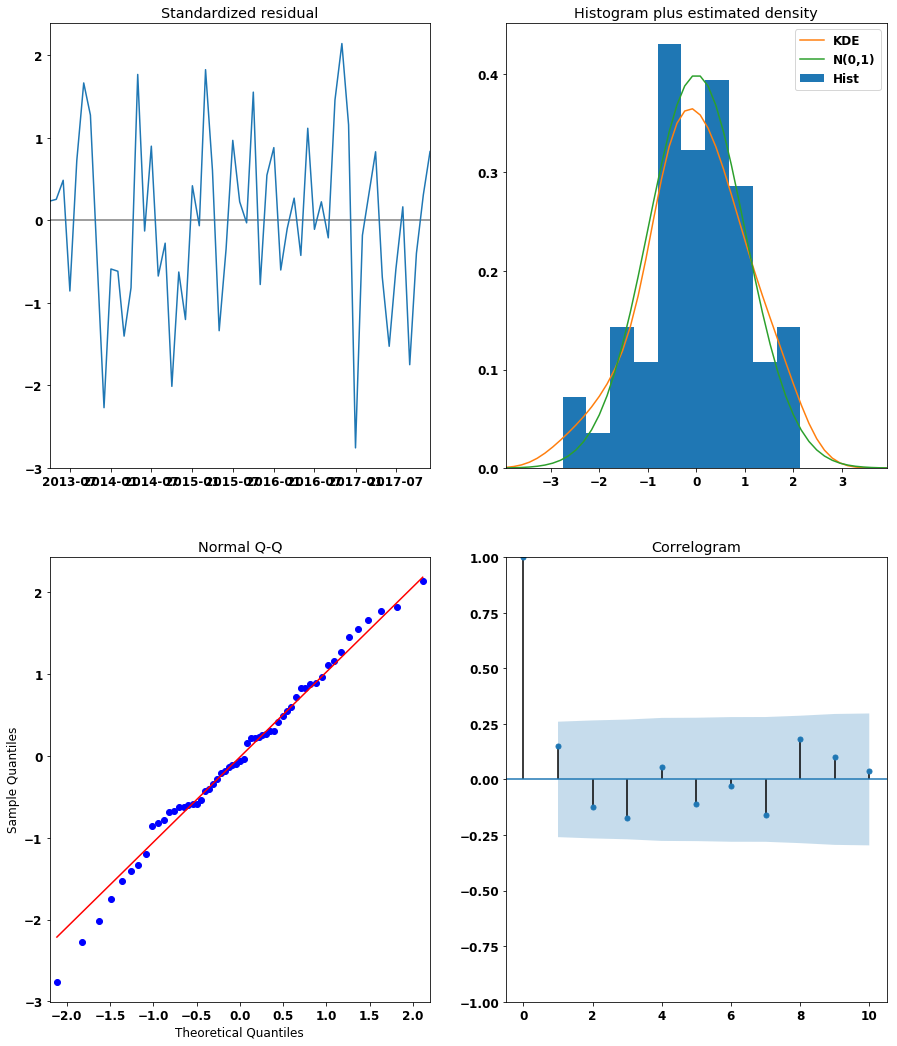

In [84]:
diagnostics_plot(model=ARIMA_MODEL)

Based on the results of the plot diagnostics, we see that our data is not normally distributed. From here, we will continue to further look into our model and attempt to improve the results by removing outliers and the residuals that are causing issues within our model.

## Making predictions using our model parameters 

In [75]:
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'))
pred_conf = pred.conf_int()

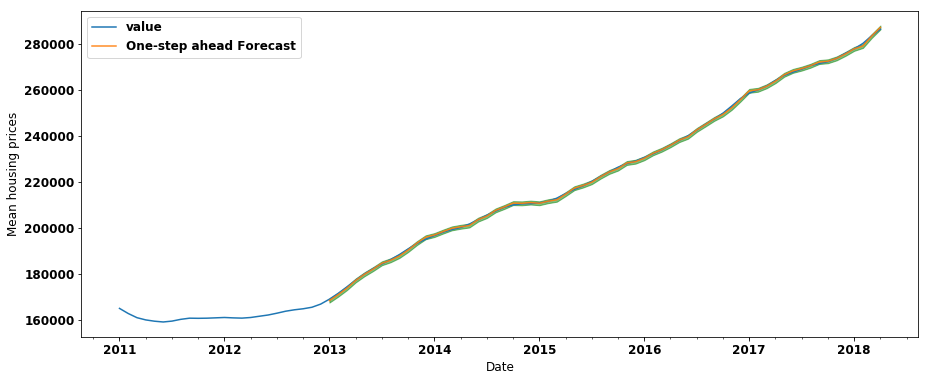

In [76]:
#Predicted vs real values with confidence intervals
rcParams['figure.figsize'] = (15, 6)

#Plot observed values for orange county
ax = orange_county['2011':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean housing prices')
plt.legend()

plt.show()

In [77]:
# Get the Real and predicted values
orange_county_forecasted = pred.predicted_mean
orange_county_truth = orange_county['2016-01-01':].value

# Compute the mean square error
mse = ((orange_county_forecasted - orange_county_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 0.07

The Mean Squared Error of our forecasts is 190817.95


# Step 6: Interpreting Results